---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib notebook

def blight_model():
    
    ## READING DATA E PREPROCESSING
    # Reading form file
    df_train = pd.read_csv("train.csv", encoding = "ISO-8859-1")
    df_test = pd.read_csv("test.csv", encoding = "ISO-8859-1")
    df_add = pd.read_csv("addresses.csv", encoding = "ISO-8859-1")
    df_latlon = pd.read_csv("latlons.csv", encoding = "ISO-8859-1")
    
    # Merging lat and lon data with train and test set
    df_add = df_add.merge(df_latlon, how="inner", left_on="address", right_on="address", copy="true")
    df_train = df_train.merge(df_add, how="inner", left_on="ticket_id", right_on="ticket_id")
    df_test = df_test.merge(df_add, how="inner", left_on="ticket_id", right_on="ticket_id")
    
    # Creating data set for classifier model
    rows_to_keep = ["judgment_amount", "lat", "lon"]
    X = df_train[rows_to_keep].copy()
    y = df_train["compliance"].copy()
    
    # Eliminating NaN from data
    list_nan = ["lat", "lon"]

    for each in list_nan:
        value = X[each].mean()
        X[each].fillna(value=value, inplace=True)

    y.fillna(value=1, inplace=True)
    
    
    ## TRAINING 
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    gradiente_clf = GradientBoostingClassifier().fit(X_train, y_train)
    
    ## OPTIONAL TESTING
    y_score_grad = gradiente_clf.decision_function(X_test)
    fpr_grad, tpr_grad, _ = roc_curve(y_test, y_score_grad)
    roc_auc_grad = auc(fpr_grad, tpr_grad)
    
    
    # Ploting ROC graph
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_grad, tpr_grad, lw=3, label='GradBoost ROC curve (area = {:0.2f})'.format(roc_auc_grad))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.show()
    
    print("AUC = {:.2f} \n".format(roc_auc_grad))
    
    
    # Confusion Matrix
    y__grad_predicted = gradiente_clf.predict(X_test)
    confusion_grad = confusion_matrix(y_test, y__grad_predicted)
    print('Gradient Boosting Classifier\n', confusion_grad)
    
    
    
    ## TEST DATA
    # Creating testing data that matches created classifier
    X_final = df_test[rows_to_keep].copy()
    
    # eliminating NaN
    for each in list_nan:
        value = X_final[each].mean()
        X_final[each].fillna(value=value, inplace=True)
    
    # predicting the probability of the test data
    y_predicted = gradiente_clf.predict_proba(X_final)
    
    #creating data series for answer
    result = pd.Series(y_predicted[:,1], index=df_test["ticket_id"])
    
    
    return result

/Users/joaopaulo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<IPython.core.display.Javascript object>


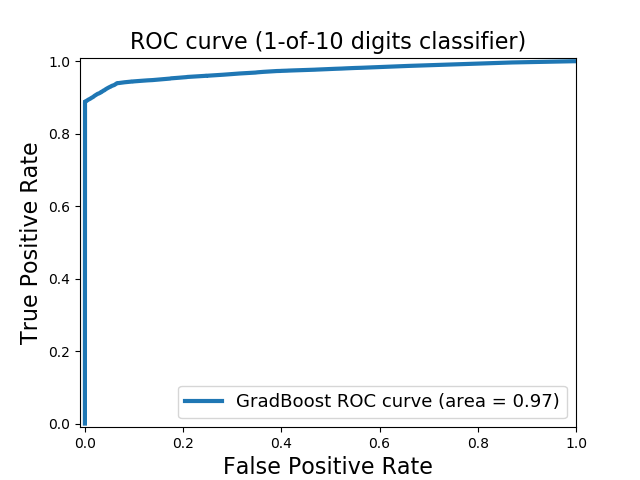

AUC = 0.97 

Gradient Boosting Classifier
 [[37106    16]
 [ 2845 22610]]


ticket_id
284932    0.064843
285362    0.025086
285361    0.074484
285338    0.069364
285346    0.084359
            ...   
376496    0.028391
376497    0.028391
376499    0.075598
376500    0.075598
369851    0.287902
Length: 61001, dtype: float64

In [52]:
blight_model()